In [1]:
!pip install facenet-pytorch
!pip install pillow == 6.2.2

ERROR: Invalid requirement: '==': Expected package name at the start of dependency specifier
    ==
    ^


In [2]:
import pandas as pd
from fastai.vision.all import *
from fastai.torch_basics import *
from PIL import Image
import os
from facenet_pytorch import InceptionResnetV1
os.listdir('/kaggle/input/employee-ids-but-better/dataset')

['images', 'labels.csv']

In [3]:
path = '/kaggle/input/employee-ids-but-better/dataset/'
images_path= path + 'images/'
test_path = '/kaggle/input/identity-employees-in-surveillance-cctv/dataset/test/images/'
csv_path = path + 'labels.csv'
csv_path

'/kaggle/input/employee-ids-but-better/dataset/labels.csv'

In [4]:
files = get_image_files(images_path)
df = pd.read_csv(csv_path)
df.head()

,filename,emp_id
0,face_0568.jpg,emp016
1,face_0433.jpg,emp014
2,face_1751.jpg,emp004
3,face_0675.jpg,emp028
4,face_0112.jpg,emp001


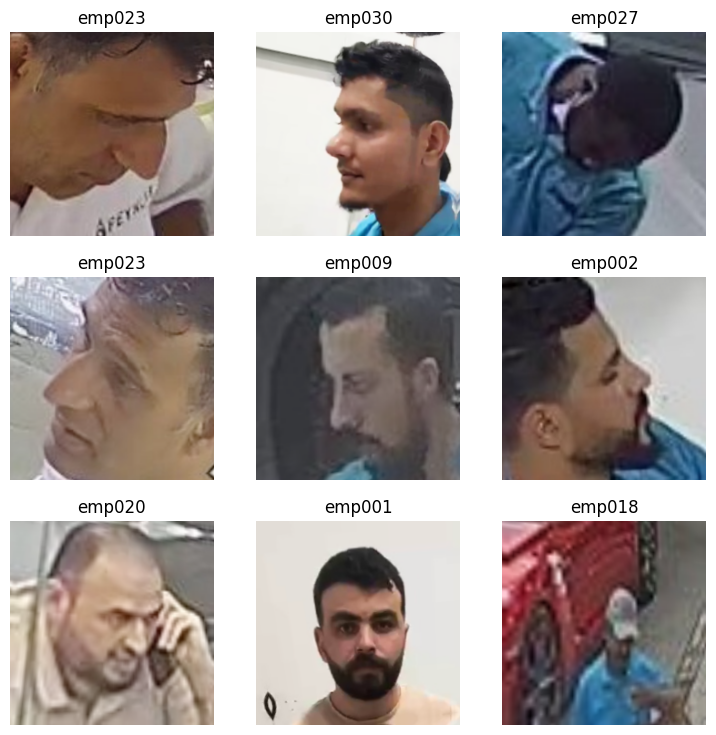

In [5]:
# Create ImageDataLoaders from CSV
dls = ImageDataLoaders.from_csv(
    path='/kaggle/input/employee-ids-but-better/dataset/',
    csv_fname='labels.csv',
    folder='images',
    fn_col='filename',
    label_col='emp_id',
    valid_pct=0.2,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224)
)
# Show batch to verify the data loading
dls.show_batch()

In [11]:
from torch import nn
from facenet_pytorch import InceptionResnetV1

# Load FaceNet backbone
facenet_backbone = InceptionResnetV1(pretrained='vggface2')  # can use 'casia-webface' too

# Freeze the backbone if needed
facenet_backbone.classify = False
facenet_backbone.eval()  # optional: only if you're not training

# Wrap into a model with a classification head
num_classes = len(dls.vocab)  # number of emp_id classes
model = nn.Sequential(
    facenet_backbone,
    nn.Linear(512, num_classes)
)

# Use FastAI learner
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fine_tune(110)  # 👈 Train for 180 epochs


epoch,train_loss,valid_loss,accuracy,time
0,3.460806,3.548176,0.064426,00:09


epoch,train_loss,valid_loss,accuracy,time
0,3.244006,3.220729,0.445378,00:09
1,3.179800,3.124621,0.593838,00:09
2,3.114945,3.039878,0.672269,00:09
3,3.045945,2.960278,0.700280,00:09
4,2.974721,2.902690,0.666667,00:09
5,2.896270,2.823365,0.719888,00:09
6,2.815407,2.806846,0.669468,00:09
7,2.730115,2.651314,0.770308,00:09
8,2.648403,2.616330,0.731092,00:09
9,2.556483,2.527707,0.708683,00:09


KeyboardInterrupt: 

In [ ]:
def predict_image(image):
	return learn.predict(test_path+image)[0]
#test_path
results = []

In [ ]:
for image in os.listdir(test_path):
	prediction = dict(filename=image, emp_id=predict_image(image))
	results.append(prediction)

In [ ]:
results_df = pd.DataFrame.from_dict(results)
hi = results_df.drop_duplicates()
hi

In [12]:
hi.to_csv('/kaggle/working/submission_fnet_fullclass_110.csv', index=False)